In [5]:
import pandas as pd

def read_csv_features(csv_file):
    # CSV 파일 읽기
    df = pd.read_csv(csv_file)
    df.columns = df.columns.str.strip()

    # 모든 feature(컬럼) 출력
    print("CSV 파일에 포함된 feature 목록:")
    print(df.columns.tolist())

    # 데이터 샘플 출력
    print("\n데이터 샘플:")
    print(df.head())

    return df.columns.tolist(), df

# 사용 예시
csv_file_path = "../document/cleaned_data_without_lat_lon_outlierslinear.csv"  # 여기에 CSV 파일 경로를 입력하세요.
features, df = read_csv_features(csv_file_path)


CSV 파일에 포함된 feature 목록:
['id', 'msg_type', 'mmsi', 'status', 'turn', 'speed', 'accuracy', 'lon', 'lat', 'course', 'heading', 'created_at', 'datetime', 'wind_direct', 'wind_speed', 'surface_curr_drc', 'surface_curr_speed', 'air_temperature', 'water_temperature', 'air_pressure', 'humidity', 'salinity', 'status_0.0', 'status_1.0', 'status_2.0', 'status_3.0', 'status_5.0', 'status_6.0', 'status_7.0', 'status_8.0', 'status_9.0', 'status_10.0', 'status_11.0', 'status_12.0', 'status_15.0', 'status_nan', 'prev_speed', 'acceleration', 'prev_heading', 'heading_diff', 'distance_km', 'avg_speed_5steps', 'avg_heading_5steps', 'prev_lat_5', 'prev_lon_5', 'position_change_5steps', 'avg_speed_10steps', 'avg_heading_10steps', 'prev_lat_10', 'prev_lon_10', 'position_change_10steps', 'avg_speed_30steps', 'avg_heading_30steps', 'prev_lat_30', 'prev_lon_30', 'position_change_30steps', 'prev_lat', 'prev_lon', 'lat_diff', 'lon_diff', 'time_diff', 'signal_loss']

데이터 샘플:
    id  msg_type       mmsi  status   

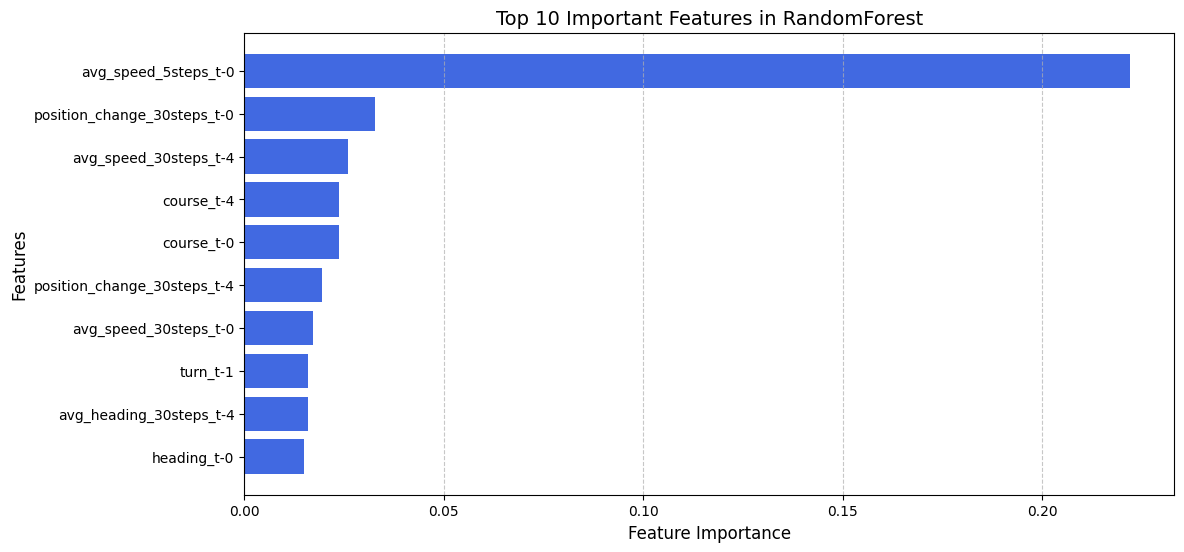

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# 데이터 로드
data = pd.read_csv('../document/cleaned_data_without_lat_lon_outlierslinear.csv')

# 날짜 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 특성과 타겟 변수 설정
selected_columns = ['turn', 'speed', 'accuracy', 'course', 'heading', 
    'wind_direct', 'wind_speed', 'surface_curr_drc', 'surface_curr_speed', 
    'air_temperature', 'water_temperature', 'air_pressure', 'humidity', 'salinity',
    'acceleration', 'heading_diff', 'distance_km', 'avg_speed_5steps', 'avg_heading_5steps',
    'position_change_5steps', 'avg_speed_10steps', 'avg_heading_10steps', 'position_change_10steps', 
    'avg_speed_30steps', 'avg_heading_30steps', 'position_change_30steps','lat_diff', 'lon_diff',
    "status_0.0", "status_1.0", "status_2.0", "status_3.0", "status_5.0", 
    "status_6.0", "status_7.0", "status_8.0", "status_9.0", "status_10.0",
    "status_11.0", "status_12.0", "status_15.0"]
target_columns = ["lat", "lon"]

# 데이터 정규화
scaler = RobustScaler()
data[selected_columns] = scaler.fit_transform(data[selected_columns])

# 시계열 데이터 변환
time_steps = 5
future_steps = [5, 10, 30]  # 5분 후, 10분 후, 30분 후 예측
X, y = [], []

for i in range(len(data) - time_steps - max(future_steps)):
    X.append(data.iloc[i:i + time_steps][selected_columns].values.flatten())  # 2D 변환
    future_targets = []
    for step in future_steps:
        future_targets.extend(data.iloc[i + step][target_columns].values)  # 1D 형태로 저장
    y.append(future_targets)

X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# ✅ 특성 중요도 분석
feature_importances = rf.feature_importances_

# 각 특성 이름 생성 (시계열 데이터로 변환된 특성을 구분하기 위해 '_t-{시점}' 추가)
flattened_feature_names = [f"{col}_t-{time_steps - 1 - t}" for t in range(time_steps) for col in selected_columns]

# 중요도 정렬
feature_importance_df = pd.DataFrame({"Feature": flattened_feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# ✅ 상위 10개 중요한 특성 시각화
top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color='royalblue')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Top 10 Important Features in RandomForest", fontsize=14)
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.gca().invert_yaxis()  # 중요도가 높은 항목을 위쪽에 위치
plt.show()


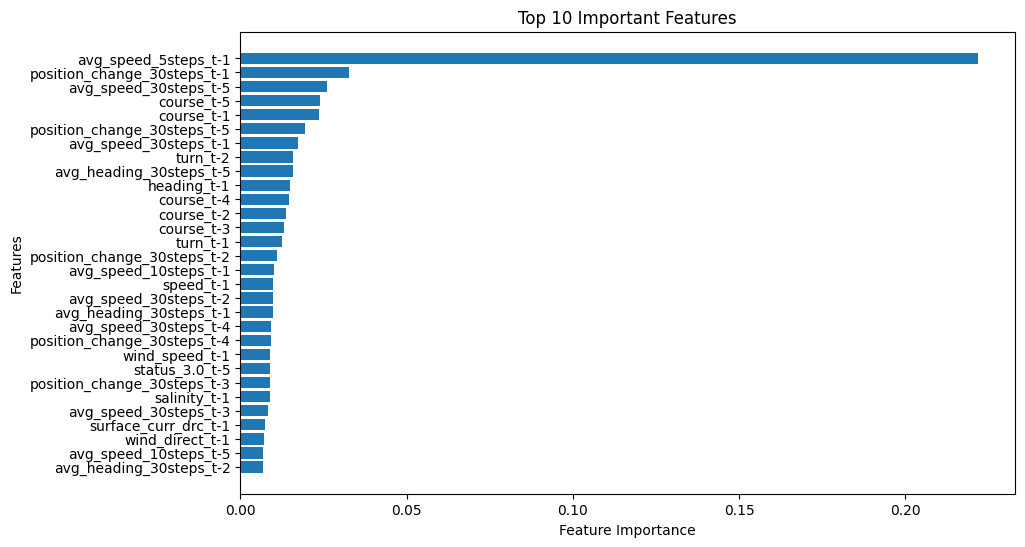

In [10]:
# 상위 10개 특성 선택
top_n = 30
top_features = feature_importance_df.head(top_n)

# 결과 출력
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterSampler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/cleaned_data_without_lat_lon_outlierslinear.csv')

# created_at 변환 및 time_diff 계산
data["created_at"] = pd.to_datetime(data["created_at"])
data["time_diff"] = data["created_at"].diff().dt.total_seconds().fillna(0)

# 독립 변수와 타겟 변수 설정
selected_columns = ['lat', 'lon', 'turn', 'speed', 'accuracy', 'course', 'heading', 
    'wind_direct', 'wind_speed', 'surface_curr_drc', 'surface_curr_speed', 
    'avg_speed_5steps', 'avg_heading_5steps', 'position_change_5steps', 
    'avg_speed_10steps', 'avg_heading_10steps', 'position_change_10steps', 
    'avg_speed_30steps', 'avg_heading_30steps', 'position_change_30steps',]

target_columns = ["lat", "lon"]  # 타겟 변수

# ✅ 로그 스케일링 적용
# 1. MinMaxScaler로 0 이상으로 정규화
scaler = MinMaxScaler(feature_range=(1, 10))  # 로그 적용을 위해 최소값 1 이상으로 조정
data[["lat", "lon"]] = scaler.fit_transform(data[["lat", "lon"]])

# 2. 로그 변환 적용
data[["lat", "lon"]] = np.log1p(data[["lat", "lon"]])


# 시계열 데이터 변환
import numpy as np

def create_sequences(data, selected_columns, target_columns, time_steps, future_steps):
    X, y = [], []

    for i in range(len(data) - time_steps - max(future_steps)):
        # 입력 시퀀스 생성
        X.append(data.iloc[i:i + time_steps][selected_columns].values)

        # 미래 시점의 타겟 값 수집
        future_targets = [data.iloc[i + time_steps + step][target_columns].values for step in future_steps]
        y.append(future_targets)

    # 리스트를 numpy 배열로 변환
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# 하이퍼파라미터 설정
time_steps = 5
future_steps = [5, 10, 30]  # 5분 후, 10분 후, 30분 후 예측

# 시퀀스 데이터 생성
X, y = create_sequences(data, selected_columns, target_columns, time_steps, future_steps)

# 결과 출력
print(f"X 크기: {X.shape}, y 크기: {y.shape}")



Using device: cuda
X 크기: (1662571, 5, 20), y 크기: (1662571, 3, 2)


In [4]:
# 데이터 분할 (학습/테스트만 나누기)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (1330056, 5, 20), (1330056, 3, 2)
Test 데이터 크기: (332515, 5, 20), (332515, 3, 2)


In [5]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler
import numpy as np

# ✅ LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 사용하여 예측
        return out.view(out.shape[0], 3, 2)  # (batch_size, 3, 2)로 변환

# ✅ 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 최적 파라미터 찾기
best_loss = float('inf')
best_params = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # ✅ output_size를 자동으로 설정
    output_size = y_train.shape[1] * y_train.shape[2]  # 미래 시점(3) × lat/lon(2) = 6

    # ✅ 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],  # feature 개수
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=output_size,  # 수정됨
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # ✅ 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size].to(device)
        y_batch = y_train_tensor[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)  # (batch_size, 3, 2)로 출력됨
        loss = criterion(outputs, y_batch)  # (batch_size, 3, 2)로 손실 계산
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # ✅ 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0097
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0098
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0061
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.0086
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.0189
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0047
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0066
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 0.0062


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0095
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 64}, Loss: 0.0172
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 128}, Loss: 0.0257
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.0132
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.0060
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0059
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.0405


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.0096
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.0059
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 128}, Loss: 0.0182
Params: {'num_layers': 4, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.0086
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.0117
최적 파라미터: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, 손실: 0.0047


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ✅ 최적 파라미터
best_params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}

# ✅ output_size 자동 설정 (3개 미래 시점 × lat/lon)
output_size = y_train.shape[1] * y_train.shape[2]  # 3 * 2 = 6

# ✅ LSTM 모델 정의 (출력 차원 자동 조정)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 출력: (batch_size, time_steps, hidden_size)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝 사용
        return out.view(out.shape[0], 3, 2)  # (batch_size, 3, 2)로 변환

# ✅ 모델 초기화
best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=output_size,  # 수정됨
    dropout=best_params['dropout']
).to(device)

# ✅ 손실 함수 (Huber Loss)
criterion = nn.SmoothL1Loss()

# ✅ 첫 번째 단계 학습 (초기 높은 학습률)
initial_lr = best_params['learning_rate']
optimizer = optim.AdamW(best_model.parameters(), lr=initial_lr)  # Adam → AdamW 변경

print("Stage 1: High Learning Rate Training")
num_epochs_stage1 = 100
for epoch in range(num_epochs_stage1):
    train_loss = 0.0
    best_model.train()
    
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']].to(device)
        y_batch = y_train_tensor[i:i+best_params['batch_size']].to(device)

        optimizer.zero_grad()
        outputs = best_model(X_batch)  # (batch_size, 3, 2)
        loss = criterion(outputs, y_batch)  # 손실 계산
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 1 - Epoch [{epoch+1}/{num_epochs_stage1}], Loss: {avg_loss:.4f}")

# ✅ 두 번째 단계 학습 (낮은 학습률로 정밀 학습)
new_lr = initial_lr * 0.5  # 기존 학습률의 절반으로 줄이기
optimizer = optim.AdamW(best_model.parameters(), lr=new_lr)  # 학습률 업데이트

print("\nStage 2: Low Learning Rate Training")
num_epochs_stage2 = 100
for epoch in range(num_epochs_stage2):
    train_loss = 0.0
    best_model.train()
    
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']].to(device)
        y_batch = y_train_tensor[i:i+best_params['batch_size']].to(device)

        optimizer.zero_grad()
        outputs = best_model(X_batch)  # (batch_size, 3, 2)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    print(f"Stage 2 - Epoch [{epoch+1}/{num_epochs_stage2}], Loss: {avg_loss:.4f}")


Stage 1: High Learning Rate Training
Stage 1 - Epoch [1/100], Loss: 0.0023
Stage 1 - Epoch [2/100], Loss: 0.0022
Stage 1 - Epoch [3/100], Loss: 0.0022
Stage 1 - Epoch [4/100], Loss: 0.0022
Stage 1 - Epoch [5/100], Loss: 0.0023
Stage 1 - Epoch [6/100], Loss: 0.0023
Stage 1 - Epoch [7/100], Loss: 0.0023
Stage 1 - Epoch [8/100], Loss: 0.0023
Stage 1 - Epoch [9/100], Loss: 0.0023
Stage 1 - Epoch [10/100], Loss: 0.0023
Stage 1 - Epoch [11/100], Loss: 0.0023
Stage 1 - Epoch [12/100], Loss: 0.0023
Stage 1 - Epoch [13/100], Loss: 0.0023
Stage 1 - Epoch [14/100], Loss: 0.0023
Stage 1 - Epoch [15/100], Loss: 0.0023
Stage 1 - Epoch [16/100], Loss: 0.0023
Stage 1 - Epoch [17/100], Loss: 0.0023
Stage 1 - Epoch [18/100], Loss: 0.0023
Stage 1 - Epoch [19/100], Loss: 0.0023
Stage 1 - Epoch [20/100], Loss: 0.0023
Stage 1 - Epoch [21/100], Loss: 0.0023
Stage 1 - Epoch [22/100], Loss: 0.0023
Stage 1 - Epoch [23/100], Loss: 0.0023
Stage 1 - Epoch [24/100], Loss: 0.0023
Stage 1 - Epoch [25/100], Loss: 0.00

In [6]:
torch.save(best_model.state_dict(), "model_engv1.pth")  # 전체 모델이 아닌 가중치만 저장

print("학습된 LSTM 모델이 model_engv1.pth 파일로 저장되었습니다!")



학습된 LSTM 모델이 model_engv1.pth 파일로 저장되었습니다!


In [ ]:
best_model.eval()
test_loss = 0.0
y_pred = []  # 예측값 저장 리스트
y_true = y_test  # NumPy 배열 그대로 사용

with torch.no_grad():
    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']].to(device)  # 배치 단위로 GPU로 이동
        y_batch = y_test_tensor[i:i+best_params['batch_size']].to(device)

        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        # 결과 저장 (GPU -> CPU 변환)
        y_pred.append(outputs.cpu().numpy())  # PyTorch 텐서를 NumPy 배열로 변환

# 예측값 변환
y_pred = np.concatenate(y_pred, axis=0)

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0147


In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ 예측 및 실제값을 비교하여 MAE와 RMSE 계산
def evaluate_model(model, X_test, y_test, batch_size=16):
    model.eval()  # 모델 평가 모드
    predictions = []
    true_values = []

    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            X_batch = X_test[i:i+batch_size].to(device)  # 배치 단위로 GPU로 이동
            y_batch = y_test[i:i+batch_size].to(device)

            outputs = model(X_batch)
            
            # GPU -> CPU 변환 및 리스트에 저장
            predictions.append(outputs.cpu().numpy())  
            true_values.append(y_batch.cpu().numpy())

    # ✅ NumPy 배열로 변환 후 차원 변환
    predictions = np.concatenate(predictions, axis=0).reshape(len(X_test), -1)  # (batch_size, 6)
    true_values = np.concatenate(true_values, axis=0).reshape(len(X_test), -1)  # (batch_size, 6)

    # ✅ MAE 계산
    mae = mean_absolute_error(true_values, predictions)

    # ✅ RMSE 계산
    rmse = np.sqrt(mean_squared_error(true_values, predictions))

    return mae, rmse

# ✅ 평가 데이터에서 MAE와 RMSE 계산
mae, rmse = evaluate_model(best_model, X_test_tensor, y_test_tensor, batch_size=8)  # batch_size 조정

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


MAE (Mean Absolute Error): 0.0872
RMSE (Root Mean Squared Error): 0.1714


In [ ]:
# ✅ 1. (batch_size, 3, 2) → (batch_size, 6)으로 변환
y_test_reshaped = y_test.reshape(y_test.shape[0], -1)  # (batch_size, 6)
y_pred_reshaped = y_pred.reshape(y_pred.shape[0], -1)  # (batch_size, 6)

# ✅ 2. 로그 변환 해제
y_test_exp = np.expm1(y_test_reshaped)  
y_pred_exp = np.expm1(y_pred_reshaped)

# ✅ 3. lat/lon을 개별적으로 역변환 (반복 적용)
y_test_original = np.zeros_like(y_test_exp)  # 원래 크기의 배열 생성
y_pred_original = np.zeros_like(y_pred_exp)

for i in range(3):  # 3개의 시점(5분 후, 10분 후, 30분 후)
    y_test_original[:, i*2:(i+1)*2] = scaler.inverse_transform(y_test_exp[:, i*2:(i+1)*2])
    y_pred_original[:, i*2:(i+1)*2] = scaler.inverse_transform(y_pred_exp[:, i*2:(i+1)*2])

# ✅ 4. 다시 (batch_size, 3, 2) 형태로 변환
y_test_original = y_test_original.reshape(y_test.shape[0], 3, 2)
y_pred_original = y_pred_original.reshape(y_pred.shape[0], 3, 2)


In [ ]:
# 역스케일링
print(f"test크기:{y_test_original.shape}")
print(f"pred크기:{y_pred_original.shape}")


test크기:(332515, 3, 2)
pred크기:(332515, 3, 2)


In [ ]:
import pandas as pd

# ✅ 전체 시점(5분 후, 10분 후, 30분 후)의 예측 결과 비교
comparison = pd.DataFrame({
    'True Lat (5min)': y_test_original[:, 0, 0],
    'True Lon (5min)': y_test_original[:, 0, 1],
    'Predicted Lat (5min)': y_pred_original[:, 0, 0],
    'Predicted Lon (5min)': y_pred_original[:, 0, 1],

    'True Lat (10min)': y_test_original[:, 1, 0],
    'True Lon (10min)': y_test_original[:, 1, 1],
    'Predicted Lat (10min)': y_pred_original[:, 1, 0],
    'Predicted Lon (10min)': y_pred_original[:, 1, 1],

    'True Lat (30min)': y_test_original[:, 2, 0],
    'True Lon (30min)': y_test_original[:, 2, 1],
    'Predicted Lat (30min)': y_pred_original[:, 2, 0],
    'Predicted Lon (30min)': y_pred_original[:, 2, 1],
})

# ✅ 데이터 미리보기 (5개 샘플 출력)
print(comparison.head())

# ✅ CSV 파일로 저장 (필요 시)
#comparison.to_csv("predicted_vs_true_coordinates.csv", index=False)


   True Lat (5min)  True Lon (5min)  Predicted Lat (5min)  \
0        35.109348       129.065445              35.10931   
1        35.109344       129.065445              35.10931   
2        35.109344       129.065445              35.10931   
3        35.109348       129.065445              35.10931   
4        35.109348       129.065445              35.10931   

   Predicted Lon (5min)  True Lat (10min)  True Lon (10min)  \
0            129.065414         35.109344        129.065445   
1            129.065414         35.109344        129.065445   
2            129.065414         35.109344        129.065445   
3            129.065414         35.109344        129.065445   
4            129.065414         35.109344        129.065445   

   Predicted Lat (10min)  Predicted Lon (10min)  True Lat (30min)  \
0               35.10931             129.065414         35.109344   
1               35.10931             129.065414         35.109344   
2               35.10931             129.065414

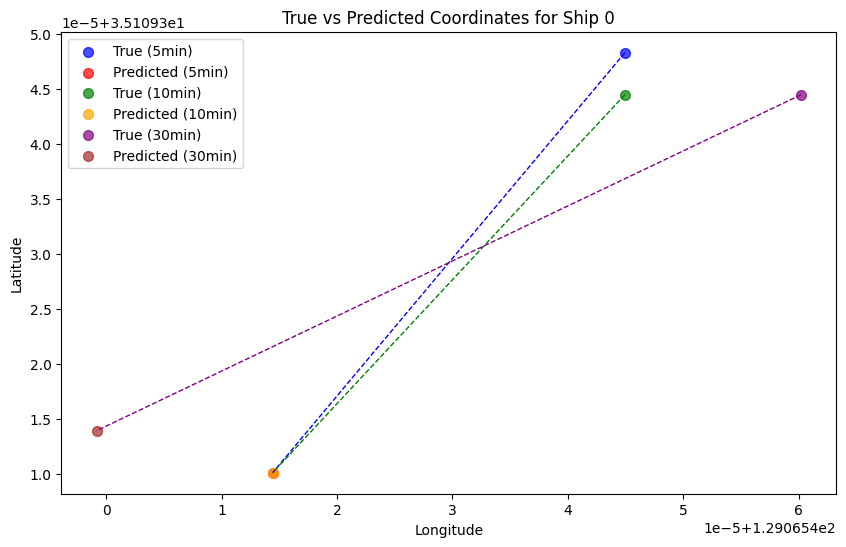

In [29]:
import matplotlib.pyplot as plt

# 특정 선박의 인덱스를 선택 (예: 첫 번째 선박 데이터)
ship_index = 0  # 원하는 선박의 인덱스로 변경 가능

plt.figure(figsize=(10, 6))

# ✅ 5분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (5min)'], comparison.loc[ship_index, 'True Lat (5min)'],
            label='True (5min)', alpha=0.7, c='blue', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (5min)'], comparison.loc[ship_index, 'Predicted Lat (5min)'],
            label='Predicted (5min)', alpha=0.7, c='red', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (5min)'], comparison.loc[ship_index, 'Predicted Lon (5min)']],
         [comparison.loc[ship_index, 'True Lat (5min)'], comparison.loc[ship_index, 'Predicted Lat (5min)']],
         c='blue', linestyle='dashed', linewidth=1)  # 선 추가

# ✅ 10분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (10min)'], comparison.loc[ship_index, 'True Lat (10min)'],
            label='True (10min)', alpha=0.7, c='green', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (10min)'], comparison.loc[ship_index, 'Predicted Lat (10min)'],
            label='Predicted (10min)', alpha=0.7, c='orange', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (10min)'], comparison.loc[ship_index, 'Predicted Lon (10min)']],
         [comparison.loc[ship_index, 'True Lat (10min)'], comparison.loc[ship_index, 'Predicted Lat (10min)']],
         c='green', linestyle='dashed', linewidth=1)  # 선 추가

# ✅ 30분 후
plt.scatter(comparison.loc[ship_index, 'True Lon (30min)'], comparison.loc[ship_index, 'True Lat (30min)'],
            label='True (30min)', alpha=0.7, c='purple', s=50)
plt.scatter(comparison.loc[ship_index, 'Predicted Lon (30min)'], comparison.loc[ship_index, 'Predicted Lat (30min)'],
            label='Predicted (30min)', alpha=0.7, c='brown', s=50)
plt.plot([comparison.loc[ship_index, 'True Lon (30min)'], comparison.loc[ship_index, 'Predicted Lon (30min)']],
         [comparison.loc[ship_index, 'True Lat (30min)'], comparison.loc[ship_index, 'Predicted Lat (30min)']],
         c='purple', linestyle='dashed', linewidth=1)  # 선 추가

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'True vs Predicted Coordinates for Ship {ship_index}')
plt.legend()
plt.show()


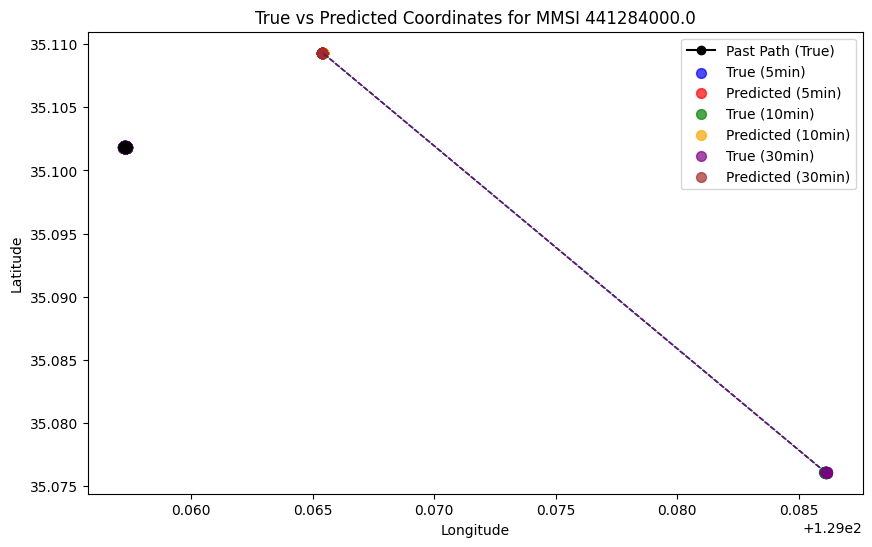

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ 컬럼명을 모두 소문자로 변환 (대소문자 문제 해결)
data.columns = data.columns.str.lower()
comparison.columns = comparison.columns.str.lower()

# ✅ MMSI 컬럼 존재 여부 확인 및 추가
if "mmsi" not in comparison.columns:
    print("⚠ Warning: 'mmsi' 컬럼이 comparison 데이터프레임에 없음. MMSI 추가 중...")
    if "mmsi" in data.columns:
        comparison["mmsi"] = data.iloc[-len(comparison):]["mmsi"].values  # MMSI 추가
    else:
        print("⚠ Warning: 'mmsi' 컬럼이 원본 데이터에도 없습니다. 임시 MMSI 생성")
        comparison["mmsi"] = np.arange(len(comparison))  # 임시 ID 부여

# ✅ 특정 MMSI 선택 (첫 번째 선박의 MMSI 가져오기)
ship_index = 0
target_mmsi = comparison.iloc[ship_index]["mmsi"]  # "mmsi" 소문자로 변경

# ✅ MMSI를 사용하여 원본 데이터에서 특정 선박의 과거 이동 경로 가져오기
past_data = data[data["mmsi"] == target_mmsi].copy()
past_data = past_data.sort_values(by="created_at")  # 시간순 정렬

# ✅ 역스케일링 함수 정의 (과거 이동 경로만 변환)
def inverse_transform_lat_lon(scaled_data, scaler):
    """
    로그 변환 해제 후 MinMaxScaler 역변환 수행
    """
    exp_data = np.expm1(scaled_data)  # 로그 변환 해제
    return scaler.inverse_transform(exp_data)  # MinMaxScaler 역변환

# ✅ 과거 이동 경로 데이터만 역스케일링 적용 (예측 좌표는 건드리지 않음)
past_data[["lat", "lon"]] = inverse_transform_lat_lon(past_data[["lat", "lon"]].values, scaler)

# ✅ 예측 데이터에서 해당 MMSI의 데이터 가져오기 (예측된 좌표는 변환하지 않음)
ship_prediction = comparison[comparison["mmsi"] == target_mmsi].copy()

# ✅ 과거 이동 경로 시각화
plt.figure(figsize=(10, 6))

# ✅ 과거 이동 경로 (실제 기록) - 역스케일링된 좌표 사용
plt.plot(past_data["lon"], past_data["lat"], linestyle='solid', color='black', marker='o', label="Past Path (True)")

# ✅ 5분 후 예측 및 실제값 시각화 (예측 좌표는 변환 X)
plt.scatter(ship_prediction["true lon (5min)"], ship_prediction["true lat (5min)"], 
            label="True (5min)", alpha=0.7, c="blue", s=50)
plt.scatter(ship_prediction["predicted lon (5min)"], ship_prediction["predicted lat (5min)"], 
            label="Predicted (5min)", alpha=0.7, c="red", s=50)
plt.plot([ship_prediction["true lon (5min)"].values[0], ship_prediction["predicted lon (5min)"].values[0]],
         [ship_prediction["true lat (5min)"].values[0], ship_prediction["predicted lat (5min)"].values[0]],
         c="blue", linestyle="dashed", linewidth=1)

# ✅ 10분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (10min)"], ship_prediction["true lat (10min)"], 
            label="True (10min)", alpha=0.7, c="green", s=50)
plt.scatter(ship_prediction["predicted lon (10min)"], ship_prediction["predicted lat (10min)"], 
            label="Predicted (10min)", alpha=0.7, c="orange", s=50)
plt.plot([ship_prediction["true lon (10min)"].values[0], ship_prediction["predicted lon (10min)"].values[0]],
         [ship_prediction["true lat (10min)"].values[0], ship_prediction["predicted lat (10min)"].values[0]],
         c="green", linestyle="dashed", linewidth=1)

# ✅ 30분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (30min)"], ship_prediction["true lat (30min)"], 
            label="True (30min)", alpha=0.7, c="purple", s=50)
plt.scatter(ship_prediction["predicted lon (30min)"], ship_prediction["predicted lat (30min)"], 
            label="Predicted (30min)", alpha=0.7, c="brown", s=50)
plt.plot([ship_prediction["true lon (30min)"].values[0], ship_prediction["predicted lon (30min)"].values[0]],
         [ship_prediction["true lat (30min)"].values[0], ship_prediction["predicted lat (30min)"].values[0]],
         c="purple", linestyle="dashed", linewidth=1)

# ✅ 그래프 스타일 설정
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"True vs Predicted Coordinates for MMSI {target_mmsi}")
plt.legend()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ✅ 컬럼명을 모두 소문자로 변환 (대소문자 문제 해결)
data.columns = data.columns.str.lower()
comparison.columns = comparison.columns.str.lower()

# ✅ MMSI 컬럼 존재 여부 확인 및 추가
if "mmsi" not in comparison.columns:
    print("⚠ Warning: 'mmsi' 컬럼이 comparison 데이터프레임에 없음. MMSI 추가 중...")
    if "mmsi" in data.columns:
        comparison["mmsi"] = data.iloc[-len(comparison):]["mmsi"].values  # MMSI 추가
    else:
        print("⚠ Warning: 'mmsi' 컬럼이 원본 데이터에도 없습니다. 임시 MMSI 생성")
        comparison["mmsi"] = np.arange(len(comparison))  # 임시 ID 부여

# ✅ MMSI 목록 확인
print("Updated MMSIs in comparison:", comparison["mmsi"].unique())  # MMSI 목록 출력

# ✅ 특정 MMSI 직접 입력 (예: 440126950)
target_mmsi = 440126950

# ✅ 해당 MMSI가 comparison에 존재하는지 확인
if target_mmsi not in comparison["mmsi"].values:
    raise ValueError(f"❌ 입력한 MMSI {target_mmsi}가 comparison 데이터프레임에 존재하지 않습니다.")

# ✅ MMSI를 사용하여 원본 데이터에서 특정 선박의 과거 이동 경로 가져오기
past_data = data[data["mmsi"] == target_mmsi].copy()
past_data = past_data.sort_values(by="created_at")  # 시간순 정렬

# ✅ MMSI를 사용하여 예측 데이터에서 특정 선박의 예측 값 가져오기
ship_prediction = comparison[comparison["mmsi"] == target_mmsi].copy()

# ✅ 과거 이동 경로 시각화
plt.figure(figsize=(10, 6))

# ✅ 과거 이동 경로 (실제 기록)
plt.plot(past_data["lon"], past_data["lat"], linestyle='solid', color='black', marker='o', label="Past Path (True)")

# ✅ 5분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (5min)"], ship_prediction["true lat (5min)"], 
            label="True (5min)", alpha=0.7, c="blue", s=50)
plt.scatter(ship_prediction["predicted lon (5min)"], ship_prediction["predicted lat (5min)"], 
            label="Predicted (5min)", alpha=0.7, c="red", s=50)
plt.plot([ship_prediction["true lon (5min)"].values[0], ship_prediction["predicted lon (5min)"].values[0]],
         [ship_prediction["true lat (5min)"].values[0], ship_prediction["predicted lat (5min)"].values[0]],
         c="blue", linestyle="dashed", linewidth=1)

# ✅ 10분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (10min)"], ship_prediction["true lat (10min)"], 
            label="True (10min)", alpha=0.7, c="green", s=50)
plt.scatter(ship_prediction["predicted lon (10min)"], ship_prediction["predicted lat (10min)"], 
            label="Predicted (10min)", alpha=0.7, c="orange", s=50)
plt.plot([ship_prediction["true lon (10min)"].values[0], ship_prediction["predicted lon (10min)"].values[0]],
         [ship_prediction["true lat (10min)"].values[0], ship_prediction["predicted lat (10min)"].values[0]],
         c="green", linestyle="dashed", linewidth=1)

# ✅ 30분 후 예측 및 실제값 시각화
plt.scatter(ship_prediction["true lon (30min)"], ship_prediction["true lat (30min)"], 
            label="True (30min)", alpha=0.7, c="purple", s=50)
plt.scatter(ship_prediction["predicted lon (30min)"], ship_prediction["predicted lat (30min)"], 
            label="Predicted (30min)", alpha=0.7, c="brown", s=50)
plt.plot([ship_prediction["true lon (30min)"].values[0], ship_prediction["predicted lon (30min)"].values[0]],
         [ship_prediction["true lat (30min)"].values[0], ship_prediction["predicted lat (30min)"].values[0]],
         c="purple", linestyle="dashed", linewidth=1)

# ✅ 그래프 스타일 설정
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"True vs Predicted Coordinates for MMSI {target_mmsi}")
plt.legend()
plt.show()


NameError: name 'data' is not defined